In [1]:
from typing import Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import yfinance as yf
from matplotlib import pyplot as plt

# Postprocess Equity & Bond Data

In [2]:
TICKERS: Tuple = ("^SPX", "AGG")
prices: pd.DataFrame = pd.DataFrame(columns=TICKERS)

for ticker in TICKERS:
    prices[ticker] = yf.download(tickers=ticker, period="max", interval="1d")["Adj Close"]

returns: pd.DataFrame = prices / prices.shift(1) - 1
returns = returns.dropna(axis=0)
returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,^SPX,AGG
Date,,
2003-09-30 00:00:00+00:00,-0.010541,0.005187
2003-10-01 00:00:00+00:00,0.022340,-0.000487
2003-10-02 00:00:00+00:00,0.001984,-0.001559
2003-10-03 00:00:00+00:00,0.009419,-0.007220
2003-10-06 00:00:00+00:00,0.004370,0.001474
...,...,...
2024-12-03 00:00:00+00:00,0.000451,-0.001921
2024-12-04 00:00:00+00:00,0.006051,0.003242
2024-12-05 00:00:00+00:00,-0.001870,0.000202


In [3]:
# Define stock vs. bond weight
weights: np.ndarray = np.array(
    [
        [0.60], 
        [0.40]
    ]
)

# Calculate the annualized arithmetic mean return
mu: float = np.mean(np.dot(returns, weights)) * 252

# Calculate the annualized volatility
sigma: float = np.std(np.dot(returns, weights)) * np.sqrt(252)

# Calculate the annualized SR
sr: float = np.mean(np.dot(returns, weights)) / np.std(np.dot(returns, weights)) * np.sqrt(252)

# Calculate Kelly-optimal leverage
optimal_leverage: float = sr / sigma

print(mu, sigma, sr, optimal_leverage)

0.07404848208559939 0.11404580833014746 0.6492871870506531 5.693213951108602


# Determine Return Autocorrelation

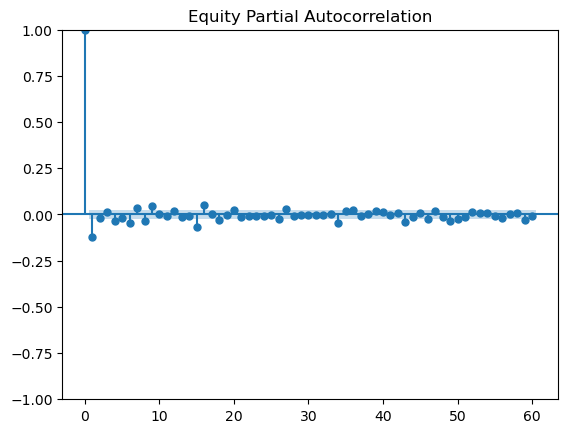

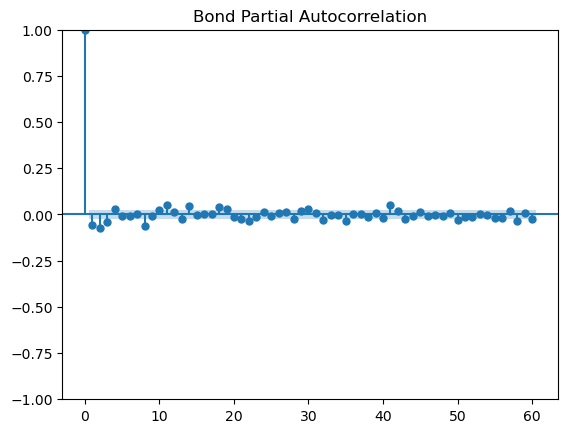

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(x=returns.iloc[:, 0], lags=60, title="Equity Partial Autocorrelation")
plt.show()


plot_pacf(x=returns.iloc[:, 1], lags=60, title="Bond Partial Autocorrelation")
plt.show()

# Implement Blocked Bootstrap Function

In [5]:
from typing import Optional, Any

def blocked_bootstrap(
    data: Union[np.ndarray, pd.DataFrame],
    n_simulations: int,
    n_observations: int,
    backward_block_length: int,
    forward_block_length: int
) -> Dict[int, Dict[int, Dict[str, Any]]]:
    """
    Perform a blocked bootstrap with asymmetric block lengths and generate multiple paths.

    Parameters:
    - data (Union[np.ndarray, pd.DataFrame]): The dataset to bootstrap. Can be 1D or 2D.
    - n_simulations (int): Number of bootstrap simulations to perform.
    - n_observations (int): Length of each bootstrap path (number of observations per simulation).
    - backward_block_length (int): Number of rows to include backward from the selected index.
    - forward_block_length (int): Number of rows to include forward from the selected index.
    """

    if not isinstance(data, np.ndarray):
        data: np.ndarray = np.array(data)

    n: int = len(data)

    # Generate random indices for bootstrap simulations
    random_indices = np.random.choice(n, size=(n_observations, n_simulations), replace=True)

    # Initialize nested dictionary for results
    bootstrap = {}

    # Perform bootstrap for each simulation
    for simulation_index  in range(n_simulations):

        simulation_indices = []

        for observation_index in range(n_observations):
        
            index = random_indices[observation_index, simulation_index]

            # Determine block range
            start = max(0, index - backward_block_length)
            end = min(n, index + forward_block_length + 1)
            
            # Convert to int for proper indexing
            simulation_indices.extend([int(i) for i in np.arange(start, end)])

            if len(simulation_indices) >= n_observations:
                break 

        # Cutoff indices that exceed the desired number of observations
        simulation_indices = simulation_indices[:n_observations]
        
        # Extract the block
        bootstrap[simulation_index] = data[simulation_indices]

    return bootstrap

Based on our PACF graphs and market experinec, we can discretionarily infer that after 20 trading days, there is no significant serial correlation. 

This will serve as our block length for Blocked Bootstrap Monte Carlo Simulations

In [7]:
# Define block length, discretionarily, from PACF
forward_block_length: int = 20
backward_block_legnth: int = 20

# Define data length
n: int = len(returns)

bootstrap_simulation = blocked_bootstrap(
    data=pd.DataFrame(returns), 
    n_observations=n, 
    n_simulations=10_000, 
    backward_block_length=backward_block_legnth,
    forward_block_length=forward_block_length
)

# Analyze Blocked Bootstrap Monte Carlo Simulation

In [8]:
sr_simulation = {}
cagr_simulation = {}
returns_simulation = {}
cumulative_returns_simulation = {}

# Define stock vs. bond weight
weights: np.ndarray = np.array(
    [
        [0.60], 
        [0.40]
    ]
)

for i, simulation_data in bootstrap_simulation.items():

    returns_simulation[i] = np.dot(simulation_data, weights)[:, 0]
    cumulative_returns_simulation[i] = (1 + returns_simulation[i]).cumprod()
    cagr_simulation[i] = cumulative_returns_simulation[i][-1] ** (252 / n) - 1
    sr_simulation[i] = np.mean(returns_simulation[i]) / np.std(returns_simulation[i]) * np.sqrt(252)

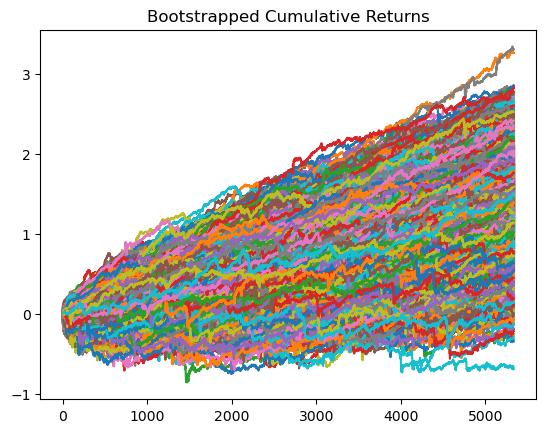

In [9]:
np.log(1 + pd.DataFrame(returns_simulation)).cumsum().plot(legend=False, title="Bootstrapped Cumulative Returns")
plt.show()

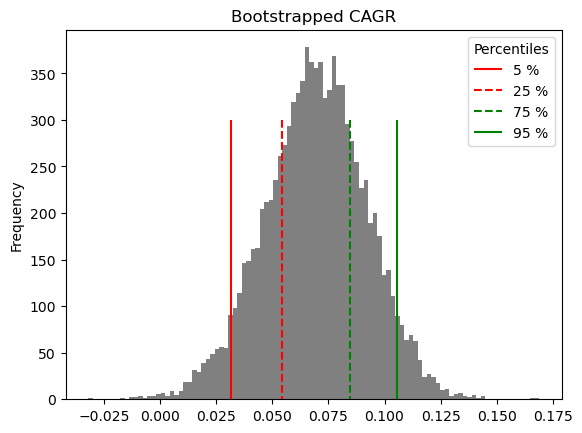

In [10]:
pd.Series(cagr_simulation).plot(kind="hist", bins=100, title="Bootstrapped CAGR", color="grey")
plt.vlines(pd.Series(cagr_simulation).quantile(0.05), ymin=300, ymax=0, color="red", linestyle="-", label="5 %")
plt.vlines(pd.Series(cagr_simulation).quantile(0.25), ymin=300, ymax=0, color="red", linestyle="--", label="25 %")
plt.vlines(pd.Series(cagr_simulation).quantile(0.75), ymin=300, ymax=0, color="green", linestyle="--", label="75 %")
plt.vlines(pd.Series(cagr_simulation).quantile(0.95), ymin=300, ymax=0, color="green", linestyle="-", label="95 %")
plt.legend(title="Percentiles")
plt.show()

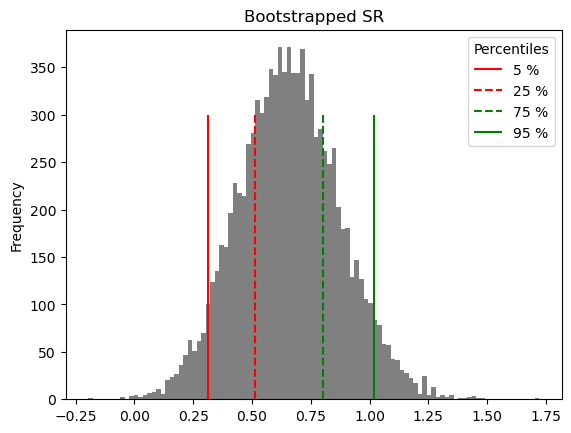

In [11]:
pd.Series(sr_simulation).plot(kind="hist", bins=100, title="Bootstrapped SR", color="grey")
plt.vlines(pd.Series(sr_simulation).quantile(0.05), ymin=300, ymax=0, color="red", linestyle="-", label="5 %")
plt.vlines(pd.Series(sr_simulation).quantile(0.25), ymin=300, ymax=0, color="red", linestyle="--", label="25 %")
plt.vlines(pd.Series(sr_simulation).quantile(0.75), ymin=300, ymax=0, color="green", linestyle="--", label="75 %")
plt.vlines(pd.Series(sr_simulation).quantile(0.95), ymin=300, ymax=0, color="green", linestyle="-", label="95 %")
plt.legend(title="Percentiles")
plt.show()

# Determine Optimal Leverage Under Uncertainty

In [12]:
del sr_simulation
del cagr_simulation
del returns_simulation
del cumulative_returns_simulation

levered_cagr_simulation = {}

sr_joint_opt_simulation = {}
cagr_joint_opt_simulation = {}
returns_joint_opt_simulation = {}

# Define stock vs. bond weight
weights: np.ndarray = np.array(
    [
        [0.60], 
        [0.40]
    ]
)

for i, simulation_data in bootstrap_simulation.items():

    levered_cagr_simulation[i] = {}

    sr_joint_opt_simulation[i] = {}
    cagr_joint_opt_simulation[i] = {}
    returns_joint_opt_simulation[i] = {}

    for leverage in np.arange(1.00, 11.00, 1.00):

        levered_cagr_simulation[i][leverage] = (1 + np.dot(simulation_data, weights)[:, 0] * leverage).cumprod()[-1] ** (252 / n) - 1

        sr_joint_opt_simulation[i][leverage] = {}
        cagr_joint_opt_simulation[i][leverage] = {}
        returns_joint_opt_simulation[i][leverage] = {}
    
        for equity_weight in np.arange(0.00, 1.10, 0.10):

            weights: np.ndarray = np.array(
                [
                    [equity_weight], 
                    [1 - equity_weight]
                ]
            )
            
            returns_joint_opt_simulation[i][leverage][equity_weight] = np.dot(simulation_data, weights)[:, 0] * leverage
            cagr_joint_opt_simulation[i][leverage][equity_weight] = (1 + returns_joint_opt_simulation[i][leverage][equity_weight]).cumprod()[-1] ** (252 / n) - 1
            sr_joint_opt_simulation[i][leverage][equity_weight] = np.mean(returns_joint_opt_simulation[i][leverage][equity_weight]) / np.std(returns_joint_opt_simulation[i][leverage][equity_weight]) * np.sqrt(252)

C:\Users\marcu\AppData\Local\Temp\ipykernel_25836\32181265.py:30: RuntimeWarning: invalid value encountered in scalar power
  levered_cagr_simulation[i][leverage] = (1 + np.dot(simulation_data, weights)[:, 0] * leverage).cumprod()[-1] ** (252 / n) - 1
C:\Users\marcu\AppData\Local\Temp\ipykernel_25836\32181265.py:46: RuntimeWarning: invalid value encountered in scalar power
  cagr_joint_opt_simulation[i][leverage][equity_weight] = (1 + returns_joint_opt_simulation[i][leverage][equity_weight]).cumprod()[-1] ** (252 / n) - 1


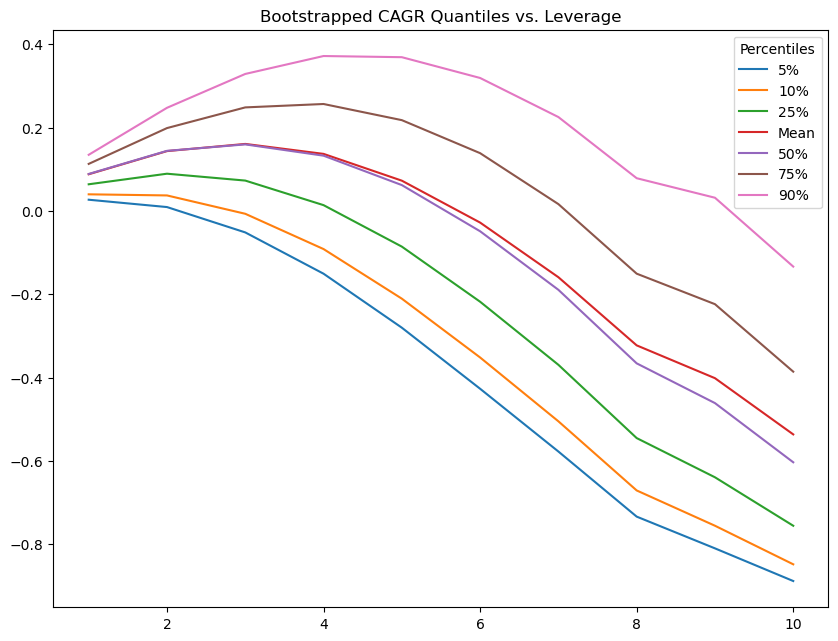

In [17]:
plt.figure(figsize=(10, 7.5))

levered_cagr_simulation_df = pd.DataFrame(levered_cagr_simulation)
levered_cagr_simulation_df.quantile(0.05, axis=1).plot(label="5%")
levered_cagr_simulation_df.quantile(0.10, axis=1).plot(label="10%")
levered_cagr_simulation_df.quantile(0.25, axis=1).plot(label="25%")
levered_cagr_simulation_df.mean(axis=1).plot(label="Mean")
levered_cagr_simulation_df.median(axis=1).plot(label="50%")
levered_cagr_simulation_df.quantile(0.75, axis=1).plot(label="75%")
levered_cagr_simulation_df.quantile(0.90, axis=1).plot(label="90%")

plt.legend(title="Percentiles")
plt.title("Bootstrapped CAGR Quantiles vs. Leverage")
plt.show()

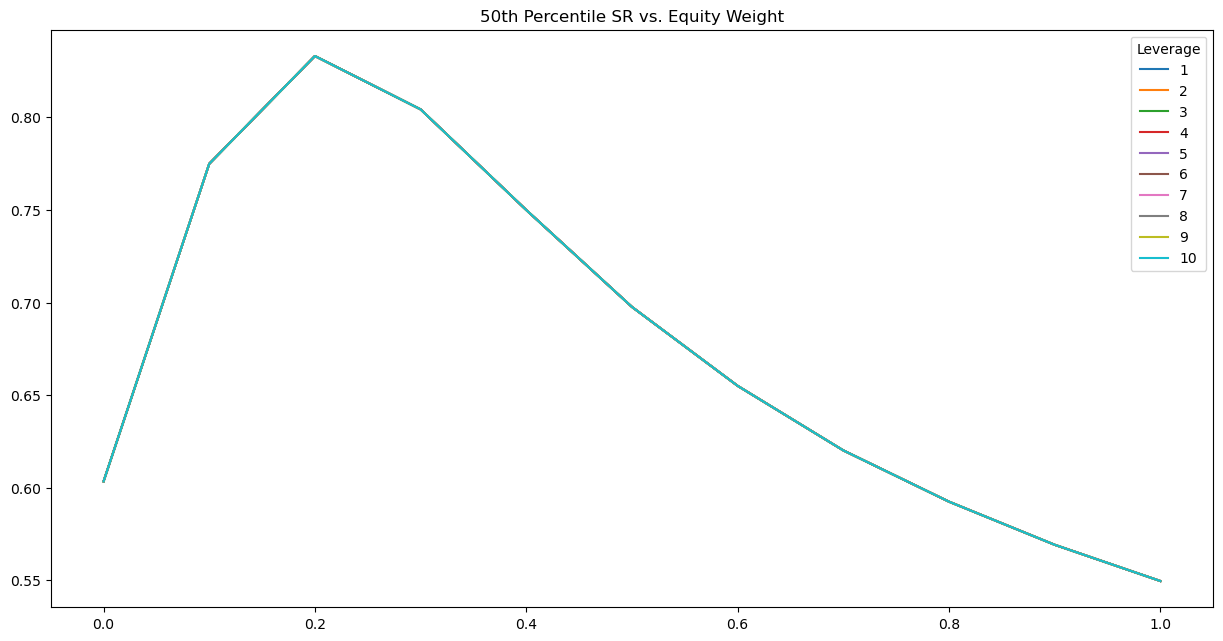

In [20]:
x = {lev: {equity_weight: {} for equity_weight in np.arange(0, 1.1, 0.1)} for lev in np.arange(1, 11)}

for i, lev_weight_sr_data in sr_joint_opt_simulation.items():
    for lev in lev_weight_sr_data.keys():
        for equity_weight in lev_weight_sr_data[lev].keys():
            x[lev][equity_weight][i] = lev_weight_sr_data[lev][equity_weight]

y = {}
for lev in x.keys():
    y[lev] = pd.DataFrame(x[lev]).quantile(0.50)
    
pd.DataFrame(y).plot(figsize=(15, 7.5), title="50th Percentile SR vs. Equity Weight")
plt.legend(title="Leverage")

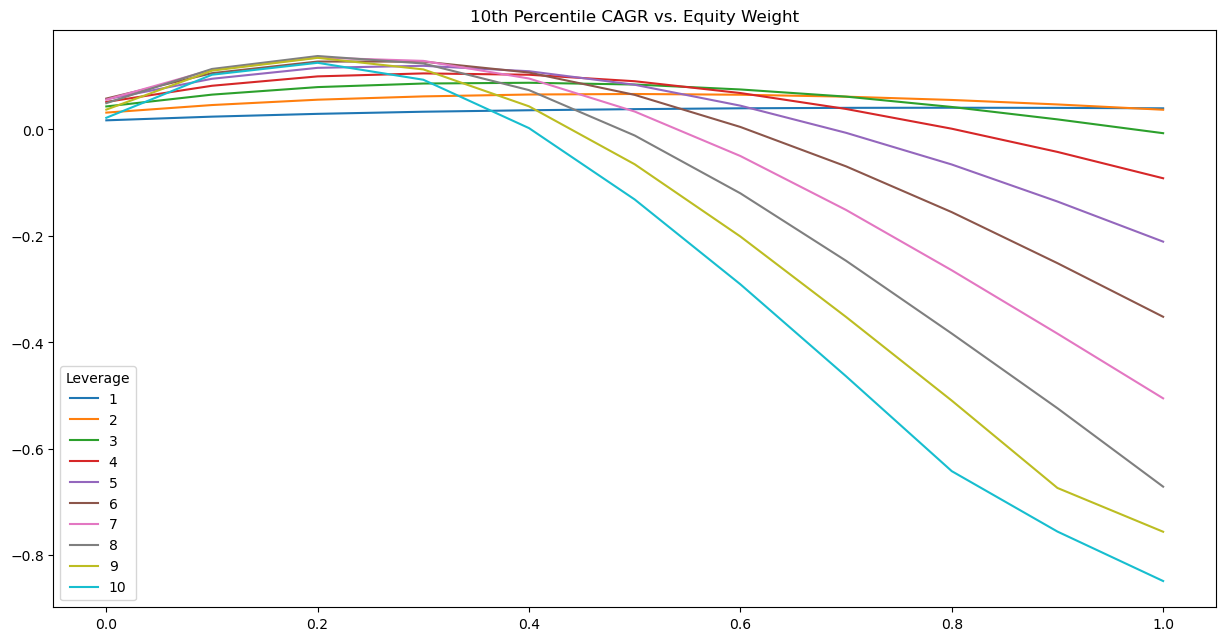

In [21]:
x = {lev: {equity_weight: {} for equity_weight in np.arange(0, 1.1, 0.1)} for lev in np.arange(1, 11)}

for i, lev_weight_sr_data in cagr_joint_opt_simulation.items():
    for lev in lev_weight_sr_data.keys():
        for equity_weight in lev_weight_sr_data[lev].keys():
            x[lev][equity_weight][i] = lev_weight_sr_data[lev][equity_weight]

y = {}
for lev in x.keys():
    y[lev] = pd.DataFrame(x[lev]).quantile(0.10)
    
pd.DataFrame(y).plot(figsize=(15, 7.5), title="10th Percentile CAGR vs. Equity Weight")
plt.legend(title="Leverage")

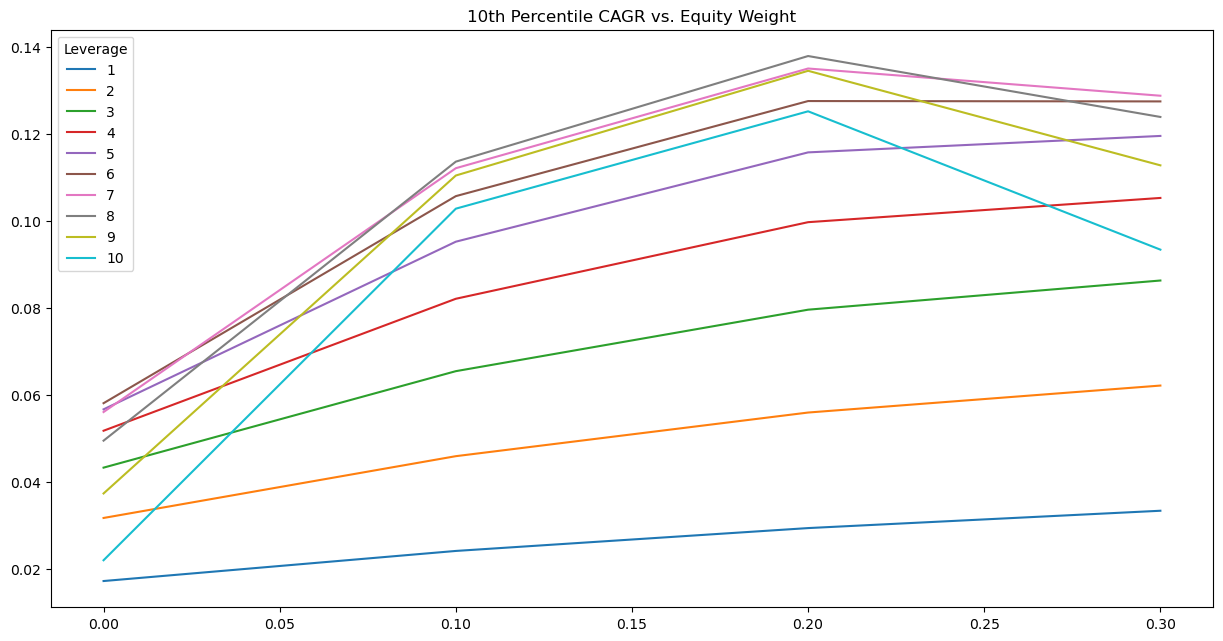

In [45]:
pd.DataFrame(y).iloc[:4].plot(figsize=(15, 7.5), title="10th Percentile CAGR vs. Equity Weight")
plt.legend(title="Leverage")

# Vol Targeted SPX vs. Passive SPX

In [77]:
TICKERS: Tuple = ("^SPX", )
prices: pd.DataFrame = pd.DataFrame(columns=TICKERS)

for ticker in TICKERS:
    prices[ticker] = yf.download(tickers=ticker, period="max", interval="1d")["Adj Close"]

returns: pd.DataFrame = prices / prices.shift(1) - 1
returns = returns.dropna(axis=0)
returns

[*********************100%***********************]  1 of 1 completed


,^SPX
Date,
1928-01-03 00:00:00+00:00,0.005663
1928-01-04 00:00:00+00:00,-0.002252
1928-01-05 00:00:00+00:00,-0.009594
1928-01-06 00:00:00+00:00,0.006268
1928-01-09 00:00:00+00:00,-0.009060
...,...
2024-12-03 00:00:00+00:00,0.000451
2024-12-04 00:00:00+00:00,0.006051
2024-12-05 00:00:00+00:00,-0.001870


In [128]:
vol_target = returns["^SPX"].std()
leverage_multiplier = np.clip(a=vol_target / returns["^SPX"].shift(2).rolling(10).std(), a_min=0.00, a_max=3.00).dropna()
leverage_multiplier

Date
1928-01-18 00:00:00+00:00    1.434022
1928-01-19 00:00:00+00:00    1.502488
1928-01-20 00:00:00+00:00    1.502537
1928-01-23 00:00:00+00:00    1.483195
1928-01-24 00:00:00+00:00    1.492416
                               ...   
2024-12-03 00:00:00+00:00    2.020489
2024-12-04 00:00:00+00:00    3.000000
2024-12-05 00:00:00+00:00    3.000000
2024-12-06 00:00:00+00:00    3.000000
2024-12-09 00:00:00+00:00    3.000000
Name: ^SPX, Length: 24340, dtype: float64

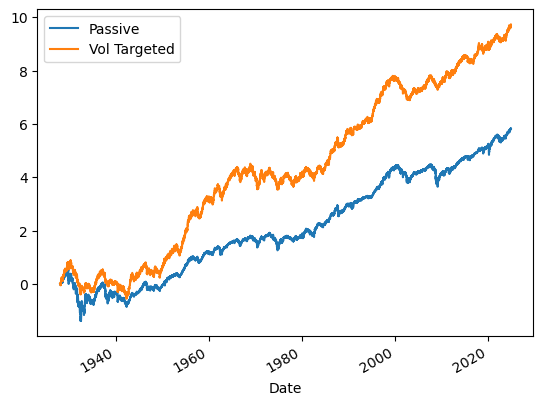

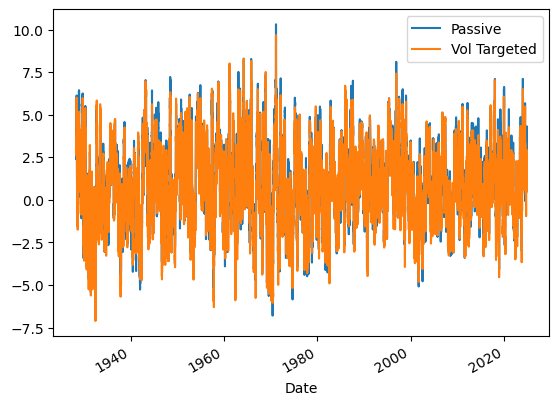

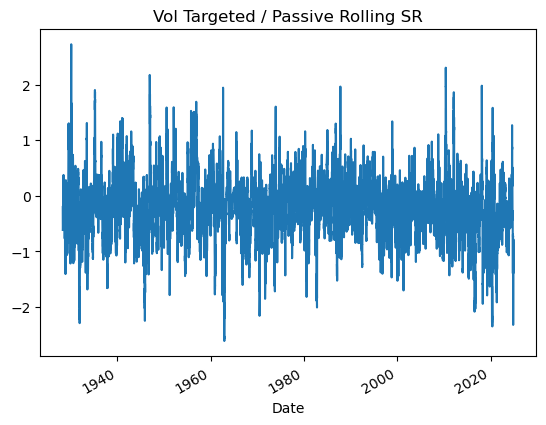

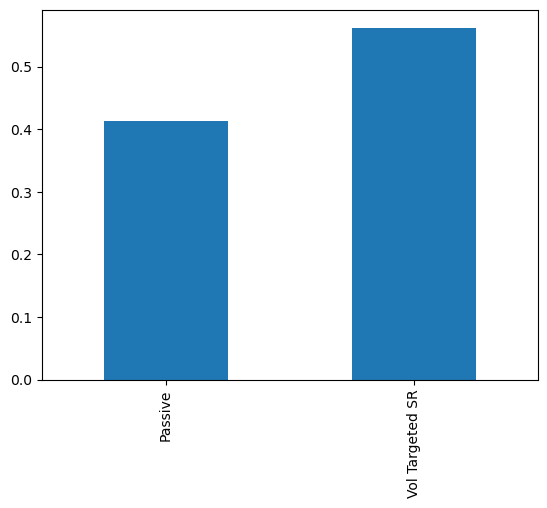

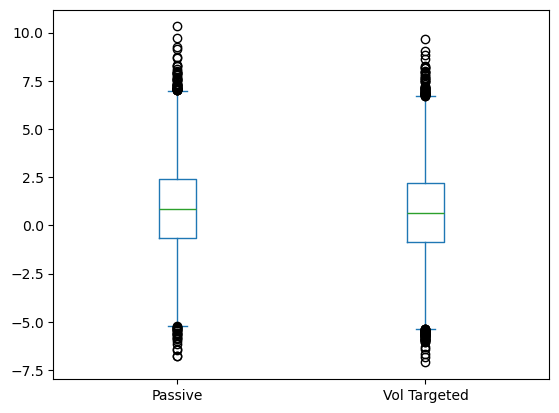

In [130]:
passive_returns = returns["^SPX"]
vol_targeted_returns = returns["^SPX"] * leverage_multiplier

np.log(1 + passive_returns).cumsum().plot(label="Passive") 
np.log(1 + vol_targeted_returns).cumsum().plot(label="Vol Targeted")
plt.legend()
plt.show()

passive_rolling_sr = passive_returns.rolling(60).mean() / passive_returns.rolling(60).std() * np.sqrt(252)
vol_targeted_rolling_sr = vol_targeted_returns.rolling(60).mean() / vol_targeted_returns.rolling(60).std() * np.sqrt(252)
delta_rolling_sr = vol_targeted_rolling_sr - passive_rolling_sr 
 
passive_rolling_sr.plot(label="Passive") 
vol_targeted_rolling_sr.plot(label="Vol Targeted")
plt.legend()
plt.show()

delta_rolling_sr.plot(title="Vol Targeted / Passive Rolling SR")
plt.show()

pd.Series({"Passive": passive_returns.mean() / passive_returns.std() * np.sqrt(252), "Vol Targeted SR": vol_targeted_returns.mean() / vol_targeted_returns.std() * np.sqrt(252)}).plot(kind="bar")
pd.DataFrame({"Passive": passive_rolling_sr, "Vol Targeted": vol_targeted_rolling_sr}).plot(kind="box", label="Passive") 
plt.show()

In [131]:
# Percent of observations where vol targeting's SR beats passive
len(delta_rolling_sr[delta_rolling_sr > 0]) / len(delta_rolling_sr)

0.31518212804402285

https://qoppac.blogspot.com/2023/12/portfolio-optimisation-uncertainty.html